In [94]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ***Set parameters***

In [0]:
#Name of the Clustering algorithm
__algo__ = "Spectral"               

#Name of the Word Embeddings used (glove, w2v, ftt), MUST set directory below
__emb__ = "ftt" #@param ["glove", "w2v", "ftt"] {allow-input: true}

#Name of Sentence Embedding algorithm used
__sentemb__ = "normalmean"            #@param ["pmeans5", "normalmean"] {allow-input: true}                 

#Number of records to be read from files
recnum =                      15000#@param {type: "number"} 

#Number of Clusters
k =                             250#@param {type: "number"} 

usesqrt = False                   #@param ["False", "True"] {type:"raw", allow-input: true}

#Random Sampling to be True/False for records which are read
randomsample = True              #@param ["False", "True"] {type:"raw", allow-input: true} 

#Directory where embeddings are saved for that selected embedding
embedDir = "./drive/My Drive/ColabOutput/FTXSentEmbs" #@param ["./drive/My Drive/ColabOutput/FTXSentEmbs", "./drive/My Drive/ColabOutput/W2VSentEmbs", "./drive/My Drive/ColabOutput/MegaSentEmbs"] {allow-input: true}


#Directory where models are saved
modelDir = "/content/drive/My Drive/Colab Notebooks/BTechProject_Venkatesh/models/"           

#Directory Where Megadf is to be saved
megadfDir = "/content/drive/My Drive/Colab Notebooks/BTechProject_Venkatesh/MegaDfs/"         

#Directory where plots are saved
plotDir = "/content/drive/My Drive/Colab Notebooks/BTechProject_Venkatesh/plots/"           

#Directory where performance and distribution params are to be stored
metadataDir = "/content/drive/My Drive/Colab Notebooks/BTechProject_Venkatesh/modelMetaData/" 

#Directory where test outcomes are saved
dumpDir = "/content/drive/My Drive/Colab Notebooks/BTechProject_Venkatesh/dump/"              

# Actual Code

### imports and time

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import cluster, datasets
from sklearn.metrics import silhouette_score, davies_bouldin_score
import seaborn as sns
import os, subprocess, sys
import datetime, time
import pickle

### File Settings

In [136]:
oldlist = os.listdir(embedDir)
filelist = sorted([embedDir+f for f in oldlist if f[-3:]=="pkl"])
filenum = len(filelist)
templist = filelist[:filenum]
smalllist = [w[:40]+"/"+w[40:] for w in templist]
print("Length of Smalllist: ", len(smalllist))

Length of Smalllist:  123


### Number of Records
It is Recommended to Set this at the top parameters

In [0]:
recnum = recnum

In [0]:
def convert2normalmean(x):
  reqlen = int(len(x)/5)
  return x[:reqlen]

### Read all the pandas dataframes

In [139]:
%%time
megadf = pd.DataFrame()

if randomsample == True:
    print("randomsample: ", randomsample)
    for f in smalllist:
        tempdf = pd.read_pickle(f)
        if __sentemb__ == "normalmean":
          tempdf["embedding"] = tempdf["embedding"].apply(convert2normalmean)
        megadf = megadf.append(tempdf, ignore_index = True)
    megadf = megadf.sample(recnum, random_state=42)
else:
    print("randomsample: ", randomsample)
    for f in smalllist:
        tempdf = pd.read_pickle(f)
        if __sentemb__ == "normalmean":
          tempdf["embedding"] = tempdf["embedding"].apply(convert2normalmean)
        megadf = megadf.append(tempdf, ignore_index = True)
        if megadf.shape[0] >= recnum:
            megadf = megadf[:recnum]
            break

print("megadf.shape: ", megadf.shape)

randomsample:  True
megadf.shape:  (15000, 3)
CPU times: user 5.03 s, sys: 3.93 s, total: 8.96 s
Wall time: 42.5 s


In [140]:
predata = megadf["embedding"]
data = np.matrix(predata.to_list())
print(data.shape)

(15000, 300)


### Number of Clusters
It is Recommended to Set this at the top parameters

In [141]:
if usesqrt == True:
    print("usesqrt: ", usesqrt)
    sqrt_k = int(np.sqrt(data.shape[0]))
    k = int(sqrt_k)
else:
    print("usesqrt: ", usesqrt)
    k = k
print("k: ", k)

usesqrt:  False
k:  250


## Clustering
Please modify the functions here to change algorithm

In [142]:
%%time
print("Starting Clustering Process")
start_time = time.time()
model = cluster.SpectralClustering(n_clusters=k, eigen_solver="arpack", random_state=42, affinity='nearest_neighbors', n_neighbors=10,  n_init = 20, n_jobs=-1)
model.fit(data)
end_time = time.time()
timetrain = round(end_time-start_time, 2)
print("done! {}".format(timetrain))
print("Spectral.fit(data) Done!")

Starting Clustering Process


/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


done! 386.39
Spectral.fit(data) Done!
CPU times: user 9min 37s, sys: 2min 54s, total: 12min 31s
Wall time: 6min 26s


### Saving the output data into vars

In [0]:
affinity = model.affinity_matrix_
labels = model.labels_
megadf["clusterlabel"]=labels
affinityDF = pd.DataFrame(affinity)


## Plotting

Text(0.5, 1.0, 'Spectral with k=250 records=15000 features=300 using ftt')

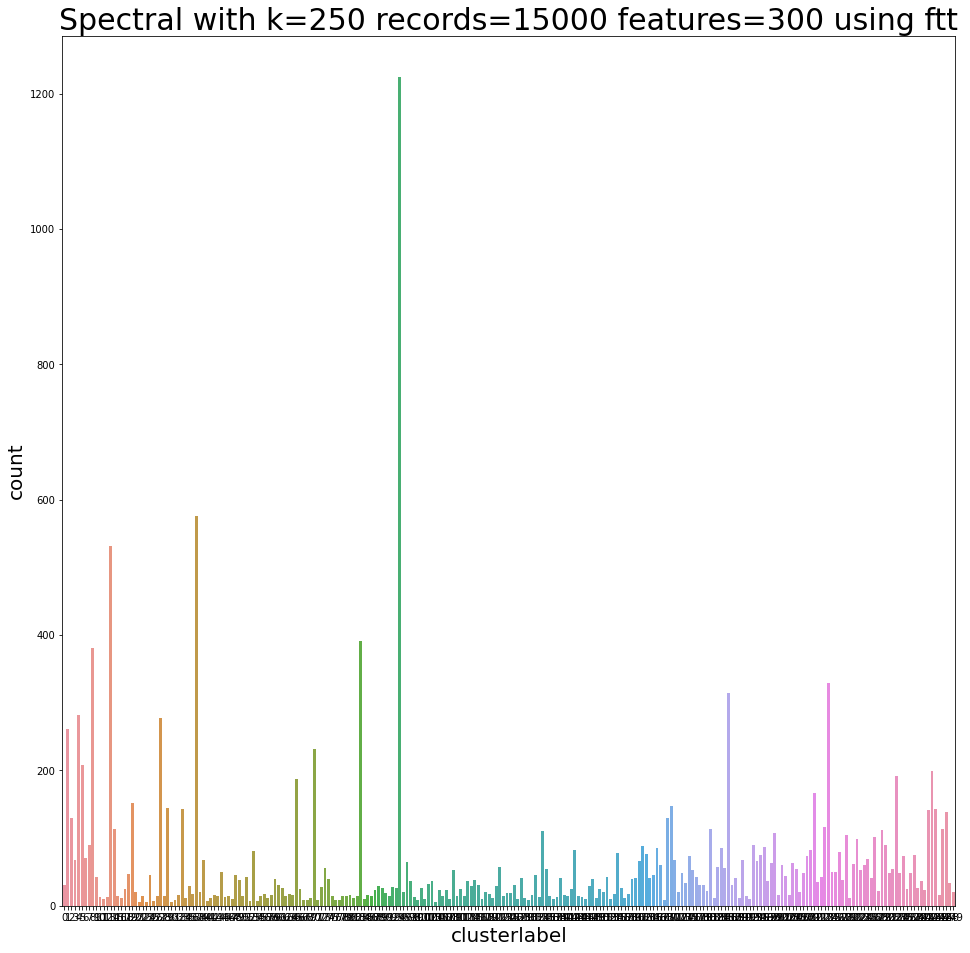

In [144]:
plt.figure(figsize=(16,16))
titlestring = "{} with k={} records={} features={} using {}".format(__algo__, k, data.shape[0], data.shape[1], __emb__)
snsplot = sns.countplot("clusterlabel", data=megadf)
snsplot.xaxis.label.set_size(20)
snsplot.yaxis.label.set_size(20)
plt.title(
        titlestring,
        fontdict = {'fontsize' : 30}
    )

### *Name given to saved files*

In [145]:
features = data.shape[1]
records = data.shape[0]
name = "{}_{}_{}_K{}_R{}_F{}".format(__algo__, __emb__, __sentemb__, k, records, features)
name

'Spectral_ftt_normalmean_K250_R15000_F300'

### Saving Data

Save model

In [0]:
modelname = "{}_model.pkl".format(name)
pickle.dump(model, open(modelDir + modelname, 'wb'))

Save Plot

In [0]:
snspltname = "{}_plt.png".format(name)
snsplot.figure.savefig(plotDir + snspltname)

Save Megadf

In [0]:
clusterdfname = "{}_clustered_megadf.pkl".format(name)
megadf.to_pickle(megadfDir + clusterdfname)

Save Affinity

In [149]:
affinityDF = pd.DataFrame(affinity)
affinityDFname = "{}_affinity.pkl".format(name)
affinityDF.to_pickle(megadfDir + affinityDFname)
print(affinityDF.shape)
print(affinityDF.columns)

(15000, 1)
RangeIndex(start=0, stop=1, step=1)


#### Open dataframe to test

In [150]:
sub = megadf[["id", "title", "clusterlabel"]]
sub.tail()

,id,title,clusterlabel
254458,228285,Context-dependent effects of parental effort o...,98
21941,75553,Development and characterisation of novel low-...,79
223394,221758,"Step up Ken Clarke, pragmatist, cigar smoker, ...",94
186729,7406447,"Bull and Mouth Hotel, no.138 Briggate",13
69097,1324788,European Bulletin of Himalayan Research (EBHR)...,5


In [151]:
megadf.columns

Index(['id', 'title', 'embedding', 'clusterlabel'], dtype='object')

# Performance Testing and Distribution


In [0]:
metadata = pd.DataFrame(columns=["Name", "Algo", "WordEmb", "SentEmb", "K", "R", "F", "SS", "CSavg", "CSmin", "CSmax", "T2Pavg", "T2LM", "T2LMP", "MEM"])

In [153]:
metadict = {
    "Name":None,                     #Name of the save file prefix
    "Algo":None,                     #Name of the Clustering algorithm
    "WordEmb":None,                  #Name of the Word Embeddings used (glove, w2v, ftt)
    "SentEmb":None,                  #Name of Sentence Embedding algorithm used 
    "K":None, "R":None, "F":None,    #Number of clusters, records and fetures
    "T2T":None,                      #Time required to train model
    "SS":None,                       #Silhoutte Score
    "DBS":None,                      #Davis Bouldin Score
    "CSavg":None,                    #Average Cluster Size
    "CSmin":None,                    #Minimum Cluster Size
    "CSmax":None,                    #Maximum Cluster Size
    "T2Pavg":None,                   #Average Time To Predict cluster of one record
    "T2LM":None,                     #Average Time to Load Model
    "T2LMP":None,                    #Amortized time to Predict after loading the model
    "MEM":None                      #Memory used by the Model
    }
metadict

{'Algo': None,
 'CSavg': None,
 'CSmax': None,
 'CSmin': None,
 'DBS': None,
 'F': None,
 'K': None,
 'MEM': None,
 'Name': None,
 'R': None,
 'SS': None,
 'SentEmb': None,
 'T2LM': None,
 'T2LMP': None,
 'T2Pavg': None,
 'T2T': None,
 'WordEmb': None}

In [154]:
metadict["Name"]=name
metadict["Algo"]=__algo__
metadict["WordEmb"]=__emb__
metadict["SentEmb"]=__sentemb__
metadict["K"]=k
metadict["R"]=recnum
metadict["F"]=features
metadict

{'Algo': 'Spectral',
 'CSavg': None,
 'CSmax': None,
 'CSmin': None,
 'DBS': None,
 'F': 300,
 'K': 250,
 'MEM': None,
 'Name': 'Spectral_ftt_normalmean_K250_R15000_F300',
 'R': 15000,
 'SS': None,
 'SentEmb': 'normalmean',
 'T2LM': None,
 'T2LMP': None,
 'T2Pavg': None,
 'T2T': None,
 'WordEmb': 'ftt'}

#### Time to train

In [0]:
metadict["T2T"]=timetrain

#### Scores

In [0]:
ss = silhouette_score(data, labels, metric = 'euclidean')
dbs = davies_bouldin_score(data, labels)
metadict["SS"]=ss
metadict["DBS"]=dbs

#### Cluster Size

In [157]:
clusterdata = megadf.groupby("clusterlabel", as_index=True).size().reset_index(name="count")
clusterdata.head()

,clusterlabel,count
0,0,30
1,1,261
2,2,129
3,3,68
4,4,282


In [0]:
clusterdfname = "{}_clustered_counts.pkl".format(name)
clusterdata.to_pickle(megadfDir + clusterdfname)

In [159]:
countdata = clusterdata.groupby("count").size().reset_index(name="clusters")
display(countdata.head(3))
display(countdata.tail(3))

,count,clusters
0,5,1
1,6,3
2,7,4


,count,clusters
102,532,1
103,576,1
104,1224,1


In [0]:
metadict["CSmax"] = max(clusterdata["count"])
metadict["CSmin"] = min(clusterdata["count"])
metadict["CSavg"] = np.mean(clusterdata["count"])

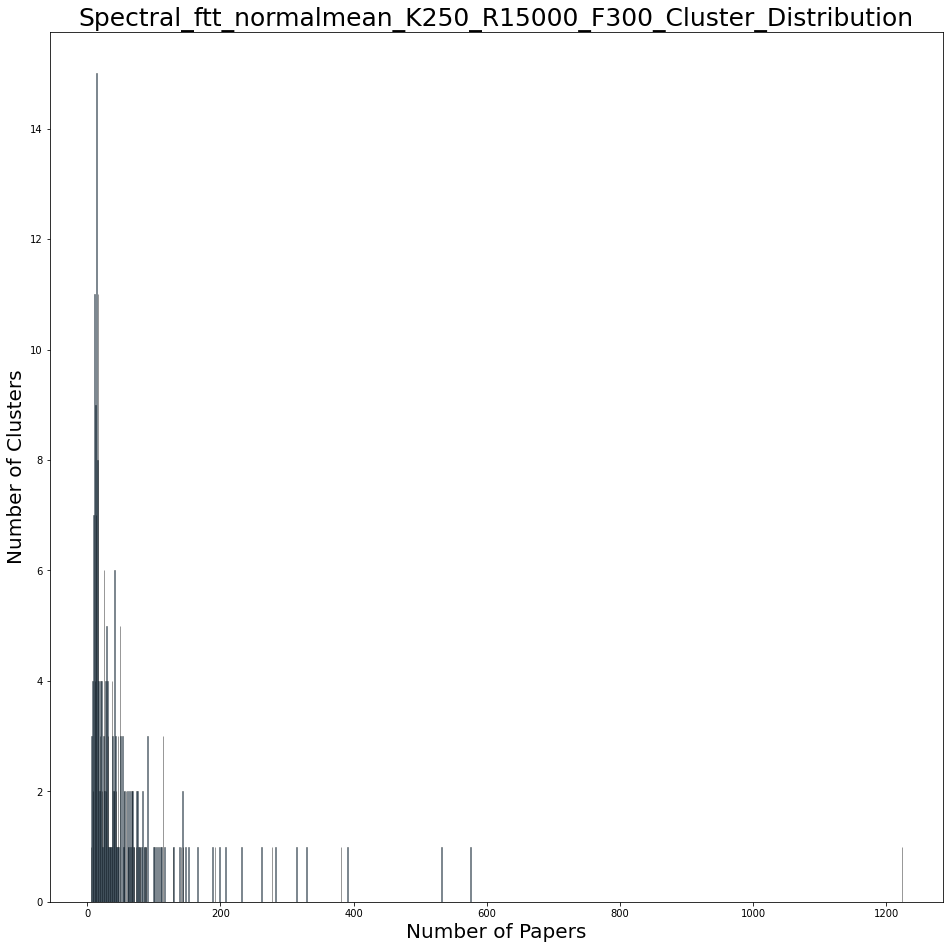

In [161]:
%matplotlib inline
plt.figure(figsize=(16,16))

sns.axes_style("whitegrid", {"axes.grid":True, 
                            'axes.spines.left': False,
                             'axes.spines.bottom': False,
                             'axes.spines.right': False,
                             'axes.spines.top': False})


titlestring = "{}_Cluster_Distribution".format(name)
snsplot = sns.distplot(clusterdata["count"], kde=False, bins=max(clusterdata["count"]),
                      hist_kws={'edgecolor':'black'},)
snsplot.set(xlabel="Number of Papers", ylabel="Number of Clusters")
snsplot.xaxis.label.set_size(20)
snsplot.yaxis.label.set_size(20)
plt.title(
        titlestring,
        fontdict = {'fontsize' : 25}
    )
plt.show()



In [0]:
snspltname = "{}_Cluster_Distribution.png".format(name)
snsplot.figure.savefig(plotDir + snspltname)

#### Prediction Time Performance

In [163]:
testdf = pd.DataFrame()
if recnum < 2000:
    samplenum = int(recnum / 10)
else:
    samplenum = 2000

for f in smalllist:
    tempdf = pd.read_pickle(f)
    if __sentemb__ == "normalmean":
      tempdf["embedding"] = tempdf["embedding"].apply(convert2normalmean)
    testdf = megadf.append(tempdf, ignore_index = True, sort = False)
testdf = testdf.sample(samplenum, random_state=int(time.time()%100000))
predata = testdf["embedding"]
data = np.matrix(predata.to_list())
print(data.shape)

(2000, 300)


In [0]:
# Spectral has no predit
# print("Starting Predicting Performance")
# testmodel = model
# start_time = time.time()
# for d in data:
#     lb = testmodel.predict(d)
# end_time = time.time()
# timetest = end_time-start_time
# avgtime = timetest/data.shape[0]
# print("Avgtime: {} Totaltime: {}".format(avgtime, timetest))
# metadict["T2Pavg"]=avgtime

In [165]:
print("Starting Loading Performance")
loadruns = 50
start_time = time.time()
for i in range(loadruns):
    testmodel = pickle.load(open(modelDir + modelname, 'rb'))
end_time = time.time()
timetest = end_time-start_time
avgtime = timetest/loadruns
print("Avgtime: {} Totaltime: {}".format(avgtime, timetest))
metadict["T2LM"] = avgtime
avgtime

Starting Loading Performance
Avgtime: 0.006072850227355957 Totaltime: 0.30364251136779785


0.006072850227355957

In [0]:
# print("Starting Amortized Performance")
# loadruns = 5
# avglist = []

# for i in range(loadruns):
#     start_time = time.time()
#     testmodel = pickle.load(open(modelDir + modelname, 'rb'))
#     for d in data:
#         lb = testmodel.predict(d)
#     end_time = time.time()
#     timetest = (end_time-start_time)/data.shape[0]
#     avglist.append(timetest)

# timetest = np.sum(avglist)
# avgtime = np.mean(avglist)
# print("Avgtime: {} Totaltime: {}".format(avgtime, timetest))
# metadict["T2LMP"] = avgtime
# avgtime

In [167]:
modelsize = sys.getsizeof(pickle.dumps(model))
print("modelsize:", modelsize, "bytes")
metadict["MEM"]=modelsize

modelsize: 3160939 bytes


In [168]:
metadict

{'Algo': 'Spectral',
 'CSavg': 60.0,
 'CSmax': 1224,
 'CSmin': 5,
 'DBS': 2.5327863174193137,
 'F': 300,
 'K': 250,
 'MEM': 3160939,
 'Name': 'Spectral_ftt_normalmean_K250_R15000_F300',
 'R': 15000,
 'SS': 0.04051506905859906,
 'SentEmb': 'normalmean',
 'T2LM': 0.006072850227355957,
 'T2LMP': None,
 'T2Pavg': None,
 'T2T': 386.39,
 'WordEmb': 'ftt'}

In [169]:
metadata = metadata.append(metadict, ignore_index=True)
metadata

,Name,Algo,WordEmb,SentEmb,K,R,F,SS,CSavg,CSmin,CSmax,T2Pavg,T2LM,T2LMP,MEM,DBS,T2T
0,Spectral_ftt_normalmean_K250_R15000_F300,Spectral,ftt,normalmean,250,15000,300,0.040515,60.0,5,1224,None,0.006073,None,3160939,2.532786,386.39


In [0]:
metadataname = "{}_metadata.pkl".format(name)
metadata.to_pickle(metadataDir + metadataname)